#0. 準備

##0.1. google driveへ接続

##0.2. ファイル名の指定と、各種パスを自動で生成

1.   INPUT_FILE : 元動画までのパス。
2.   最終的に保存するディレクトリ。
3.   main_CSV_FILE : 今回注目する関節座標データ(メイン)までのパスとファイル名
3.   sub_CSV_FILE : 比較する関節座標データ(サブ)までのパスとファイル名
5.   グラフ化する関節名をリストにする。(csvのcolumn名と表記を統一させる。)

In [25]:
#------------------------------------------------------------------------------
#ここを変更
#------------------------------------------------------------------------------
INPUT_FILE="/content/drive/My Drive/datasets/C0003.MP4" #原本動画までのパス #ここで動画名を指定すれば、関節座標を記録したcsv (動画と同じディレクトリに保存されている) までのパスとファイル名も自動で作成される。
OUTPUT_PATH="/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/" #最終的に動画をどこのディレクトリへ保存するか。
main_CSV_FILE= "/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0003.csv"
sub_CSV_FILE_01="/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv"
sub_CSV_FILE_02="/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv"
sub_CSV_FILE_03="/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv"
sub_CSV_FILE_04="/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv"
sub_CSV_FILE_05="/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv"

list_SELECTED_KEYPOINT=['left_shoulder_y', 'right_shoulder_y', 'left_elbow_y', 'right_elbow_y', 'left_wrist_y', 'right_wrist_y', 'middle_chest_y',	'from_Rhand_to_chest',	'from_Lhand_to_chest'] #bodyRegion='部位(?)'
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#removed pathANDformat from videoFile  by mayo 
#------------------------------------------------------------------------------
INPUT_FILE_splited_path=INPUT_FILE.split('/')
INPUT_FILE_removed_pathANDformat=INPUT_FILE_splited_path[-1].split(".")
INPUT_FILE_removed_pathANDformat=INPUT_FILE_removed_pathANDformat[0]

POSE_FILE=OUTPUT_PATH+'pose_%s.MP4' % INPUT_FILE_removed_pathANDformat
OUTPUT_FILE= OUTPUT_PATH+ "pose_%s.MP4" % INPUT_FILE_removed_pathANDformat
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#main_CSV_FILEのパス名について、本来は自動で生成される。
#関節座標を記録したcsv (動画と同じディレクトリに保存されている前提) までのパスとファイル名を生成
#------------------------------------------------------------------------------
#main_CSV_FILE= OUTPUT_PATH+ "pose-data_%s.csv" % INPUT_FILE_removed_pathANDformat
print(main_CSV_FILE)
print(sub_CSV_FILE_01)
#------------------------------------------------------------------------------

/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0003.csv
/content/drive/MyDrive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv


#1. 関節座標の取得



##1.1. csvからdfへ変換

df_A : メインとなる関節座標

df_B : その比較に使う関節座標

In [26]:
import pandas as pd
import re

list_frames=[]
list_frames.clear()
def read_file_keypoints(CSV_FILE):
    df=pd.read_csv(CSV_FILE, encoding = "shift-jis")
    df=df.set_index('frame')
    vertical_len, horizon_len=df.shape
    #print(x_len, y_len)
      
    return df, vertical_len

df_A, frames_A=read_file_keypoints(main_CSV_FILE)
df_B, frames_B=read_file_keypoints(sub_CSV_FILE_01)
df_C, frames_C=read_file_keypoints(sub_CSV_FILE_02)
df_D, frames_D=read_file_keypoints(sub_CSV_FILE_03)
df_E, frames_E=read_file_keypoints(sub_CSV_FILE_04)
df_F, frames_F=read_file_keypoints(sub_CSV_FILE_05)

min_frames=min(frames_A, frames_B, frames_C, frames_D, frames_E, frames_F)
print(min_frames)

240


##1.2. dfの確認

In [27]:
'''df_A
df_B
df_C
df_D
df_E
df_F'''


'df_A\ndf_B\ndf_C\ndf_D\ndf_E\ndf_F'

##1.3. 原点を鼻に変更する。(カメラのアングルに左右されないため。)

In [28]:
import numpy as np

def change_origin_of_coordinates(df):
  list_colums_name=list(df.columns)
  #------------------------------------------------------------------------------
  #nose_x, yはリストの最後尾に移動させる。
  #------------------------------------------------------------------------------
  list_colums_name.append(list_colums_name.pop(0))
  list_colums_name.append(list_colums_name.pop(0))
  #------------------------------------------------------------------------------
  #それぞれの関節座標をnose_x,yの座標でひく
  #------------------------------------------------------------------------------
  for element in list_colums_name:
    if re.search('_x', element):
      df[element]=df[element]-df['nose_x']
    elif re.search('_y', element):
      df[element]=df[element]-df['nose_y']
    
  return df

df_A=change_origin_of_coordinates(df_A)
df_B=change_origin_of_coordinates(df_B)
df_C=change_origin_of_coordinates(df_C)
df_D=change_origin_of_coordinates(df_D)
df_E=change_origin_of_coordinates(df_E)
df_F=change_origin_of_coordinates(df_F)

##1.4. 関節部位の追加

4つの特徴量を追加する。



1.   middle_chest_x ←胸の中心 (x座標)
2.   middle_chest_y ←胸の中心 (y座標)
3.   wrist_chest_distance_right ←胸と右手首までの距離 (y座標のみ)
4.   wrist_chest_distance_left ←胸と左手首までの距離 (y座標のみ)



In [29]:
import numpy as np
#df_A

def expand_bodyRegion(df_element):
  df_element['middle_chest_x']=np.sqrt((df_element['left_shoulder_x']-df_element['right_shoulder_x'])**2)
  df_element['middle_chest_y']=np.sqrt((df_element['left_shoulder_y']-df_element['right_shoulder_y'])**2)

  df_element['from_Rhand_to_chest']=np.sqrt((df_element['middle_chest_x']- df_element['right_wrist_x'])**2+(df_element['middle_chest_x'] - df_element['right_wrist_y'])**2)
  df_element['from_Lhand_to_chest']=np.sqrt((df_element['middle_chest_y'] - df_element['left_wrist_x'])**2+(df_element['middle_chest_y'] - df_element['left_wrist_y'])**2)

  return df_element

df_A=expand_bodyRegion(df_A)
df_B=expand_bodyRegion(df_B)
df_C=expand_bodyRegion(df_C)
df_D=expand_bodyRegion(df_D)
df_E=expand_bodyRegion(df_E)
df_F=expand_bodyRegion(df_F)

##1.5. 確認

In [30]:
#df_A
#df_B
#df_C
#df_D
#df_E
#df_F
df_E

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,middle_chest_x,middle_chest_y,from_Rhand_to_chest,from_Lhand_to_chest
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,21,-9,0,-13,59,0,64,4,21,71,102,55,106,109,211,50,76,173,144,38,72,316,21,312,-25,414,26,443,64,566,93,549,81.0,16.0,76.275815,168.074388
1,0,0,21,-13,0,-18,59,0,-9,-13,17,68,89,46,110,106,213,51,81,174,140,42,68,311,17,307,-22,409,-22,422,81,558,85,545,72.0,22.0,74.323617,163.049072
2,0,0,17,-9,0,-17,60,4,-8,-13,21,68,90,60,116,107,210,51,81,180,141,43,69,316,13,308,-21,415,21,440,60,564,86,547,69.0,8.0,76.550637,186.850207
3,0,0,17,-8,-4,-12,60,5,-13,-12,26,73,85,52,115,115,209,56,81,192,136,35,64,311,13,311,-17,418,-4,426,51,566,81,549,59.0,21.0,80.653580,181.220860
4,0,0,21,-8,0,-13,59,4,-9,-8,30,72,102,51,119,123,208,55,89,191,136,34,68,315,13,310,-13,417,-9,425,51,565,76,548,72.0,21.0,74.431176,183.095603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0,0,6,-16,-16,-10,11,-16,-59,-10,-80,11,-86,92,-145,6,-86,194,-75,145,-64,269,-177,226,-252,188,-145,377,-413,317,-118,511,-467,119,6.0,81.0,272.156205,168.617911
236,0,0,5,-16,-16,-10,11,-16,-59,-10,-81,11,-86,92,-145,6,-86,194,-75,140,-64,269,-177,226,-252,188,-145,376,-413,317,-118,511,-467,119,5.0,81.0,272.868100,166.784292
237,0,0,5,-16,-16,-11,11,-16,-59,-11,-81,11,-86,91,-145,5,-86,193,-75,139,-64,268,-177,225,-258,188,-145,381,-413,316,-118,510,-472,118,5.0,80.0,271.900717,165.849329


In [31]:
df_C= df_C + 10
df_D= df_D + 20
df_E= df_E + 30
df_F= df_F + 50

#2. 関節座標を時間遷移でアニメーショングラフ化

##2.0. matplotの日本語フォントをダウンロード

In [32]:
!pip install japanize-matplotlib

##2.1. 部位ごとに静止画のグラフ化する。

plotting left_shoulder_y ...




       left_shoulder_y Done!

plotting right_shoulder_y ...

       the directory already exists




       right_shoulder_y Done!

plotting left_elbow_y ...

       the directory already exists




       left_elbow_y Done!

plotting right_elbow_y ...

       the directory already exists




       right_elbow_y Done!

plotting left_wrist_y ...

       the directory already exists




       left_wrist_y Done!

plotting right_wrist_y ...

       the directory already exists




       right_wrist_y Done!

plotting middle_chest_y ...

       the directory already exists




       middle_chest_y Done!

plotting from_Rhand_to_chest ...

       the directory already exists




       from_Rhand_to_chest Done!

plotting from_Lhand_to_chest ...

       the directory already exists




       from_Lhand_to_chest Done!



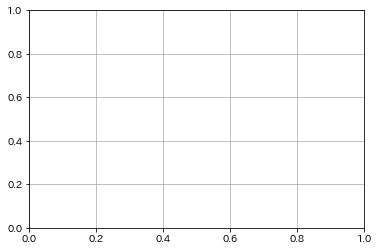

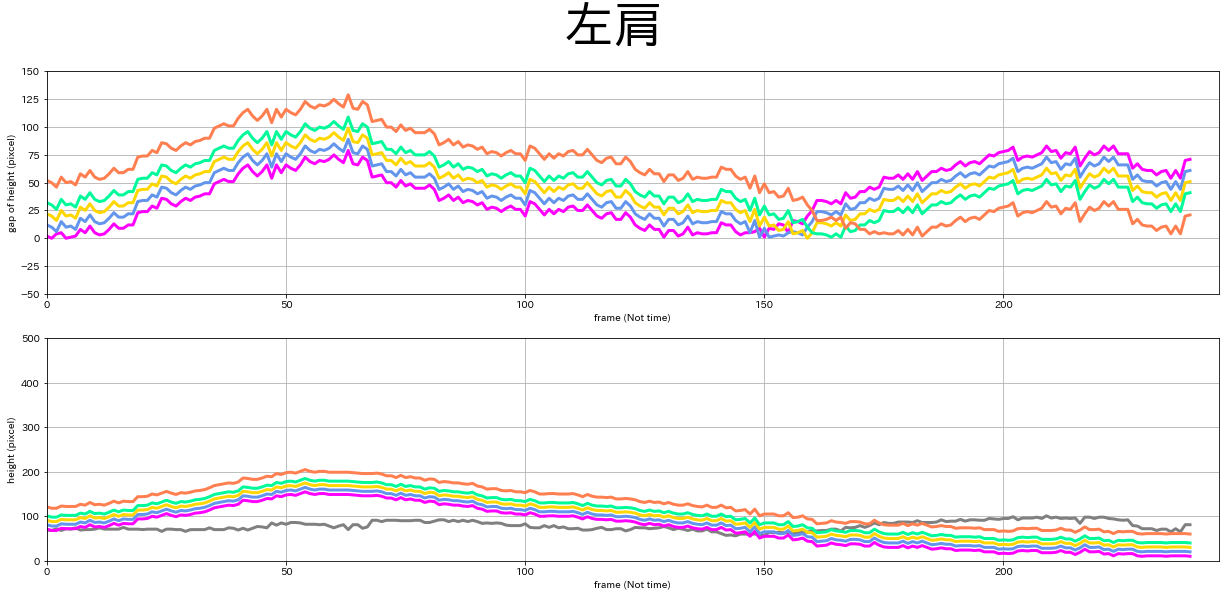

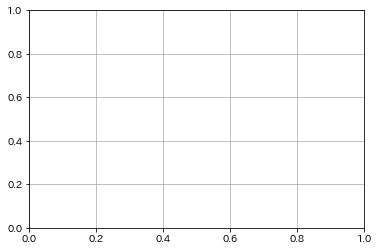

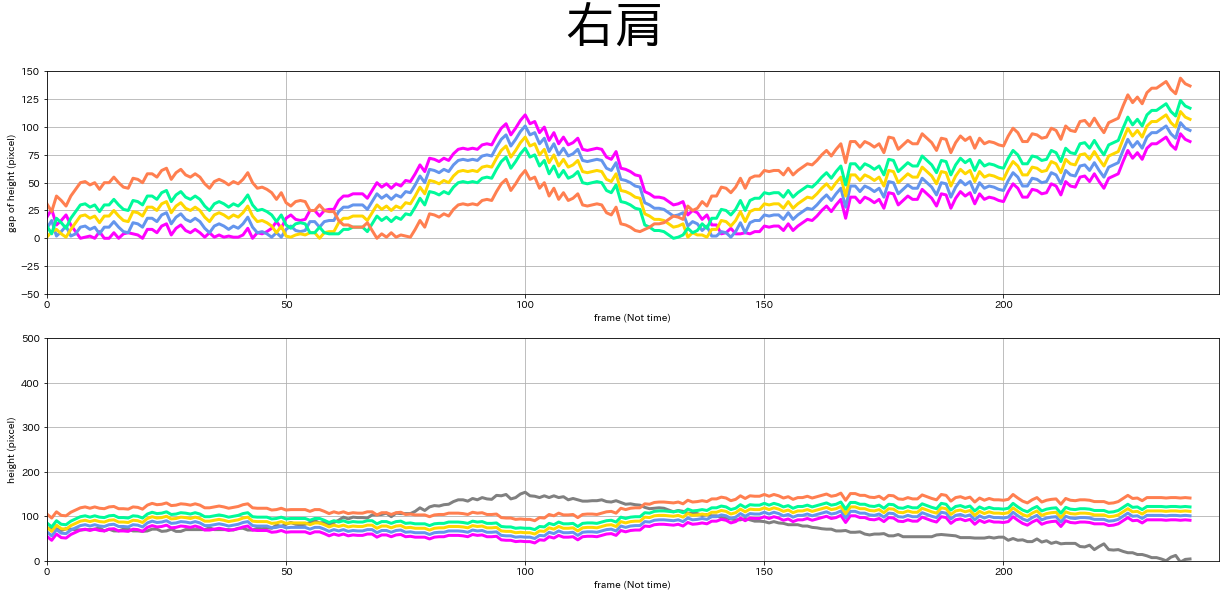

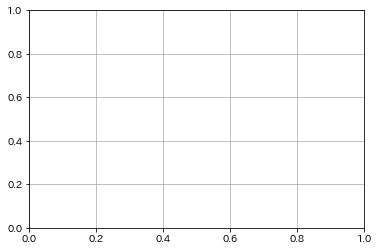

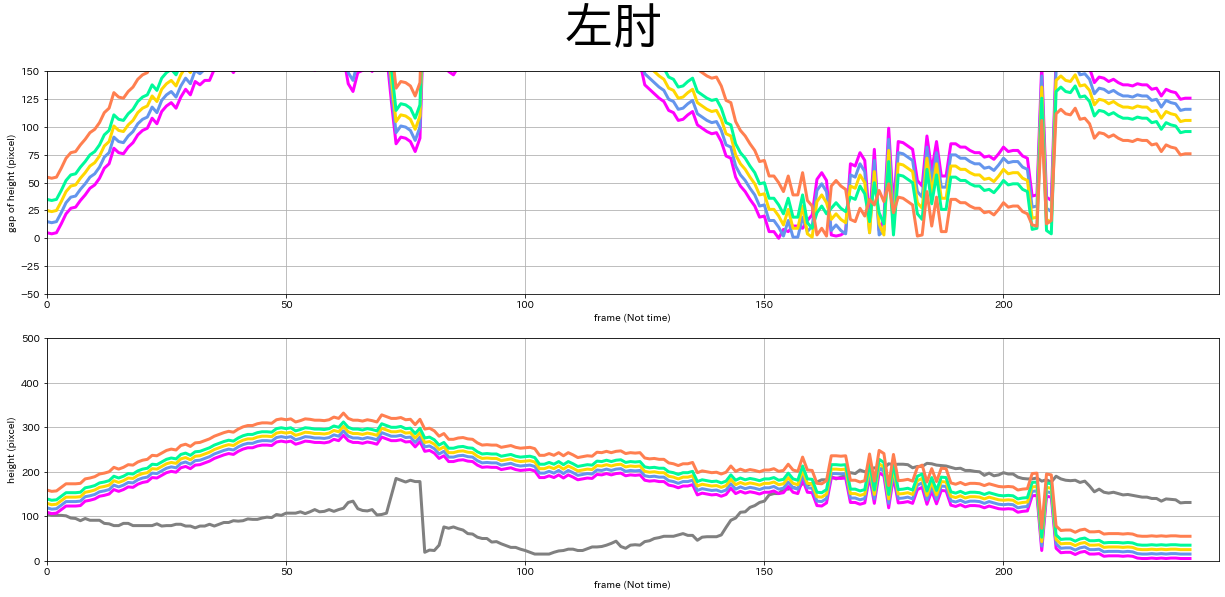

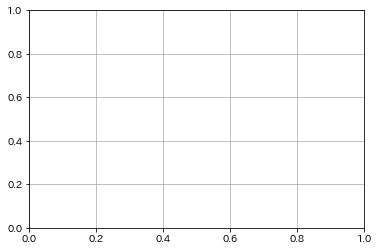

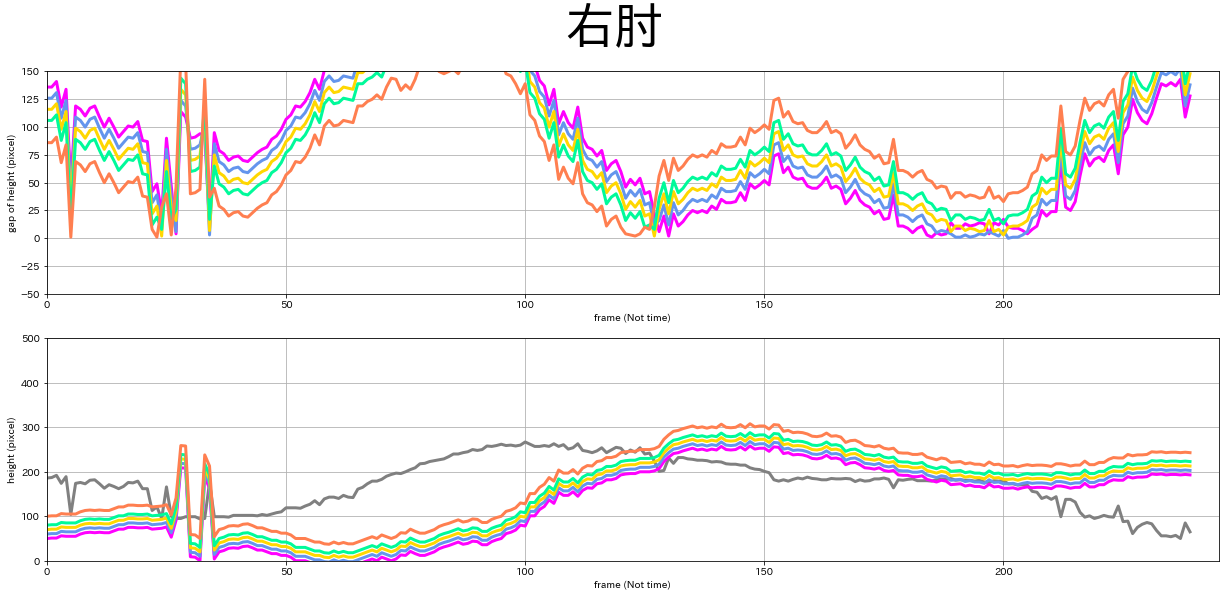

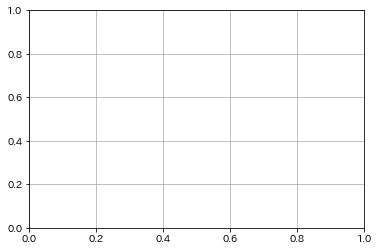

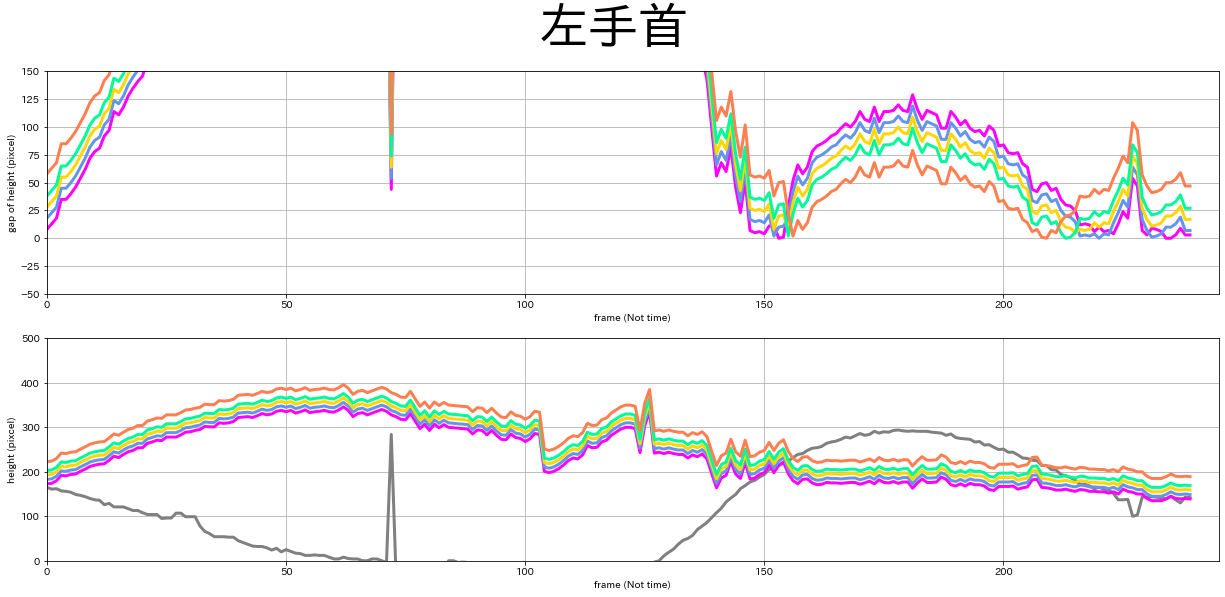

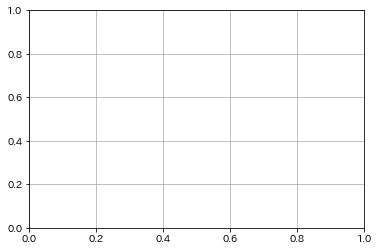

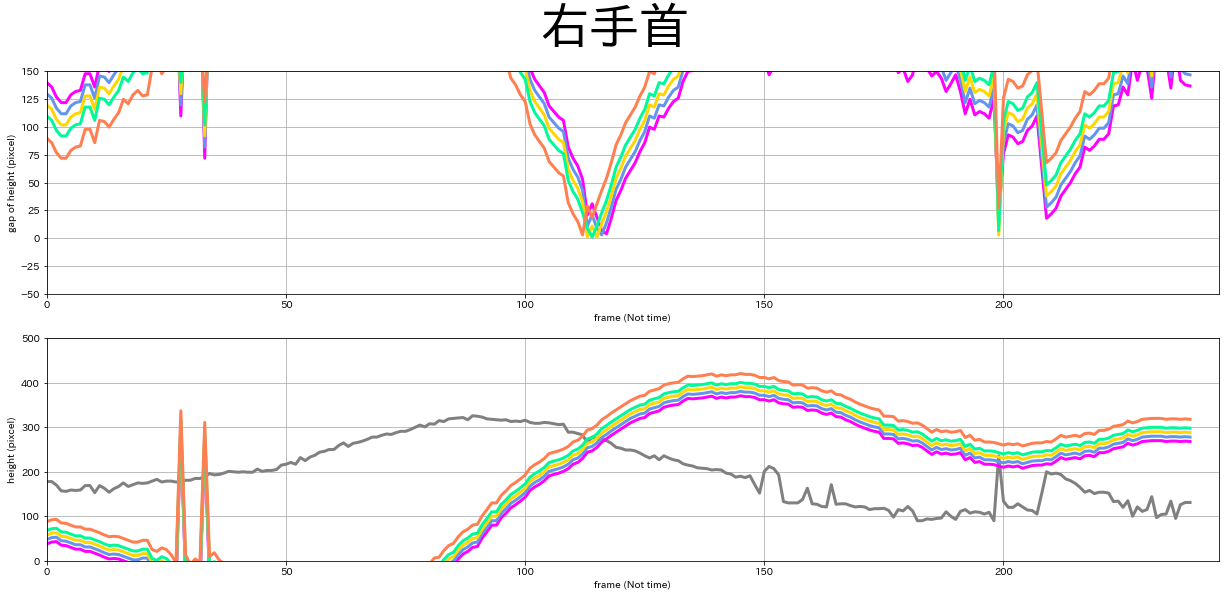

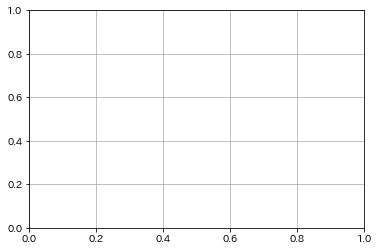

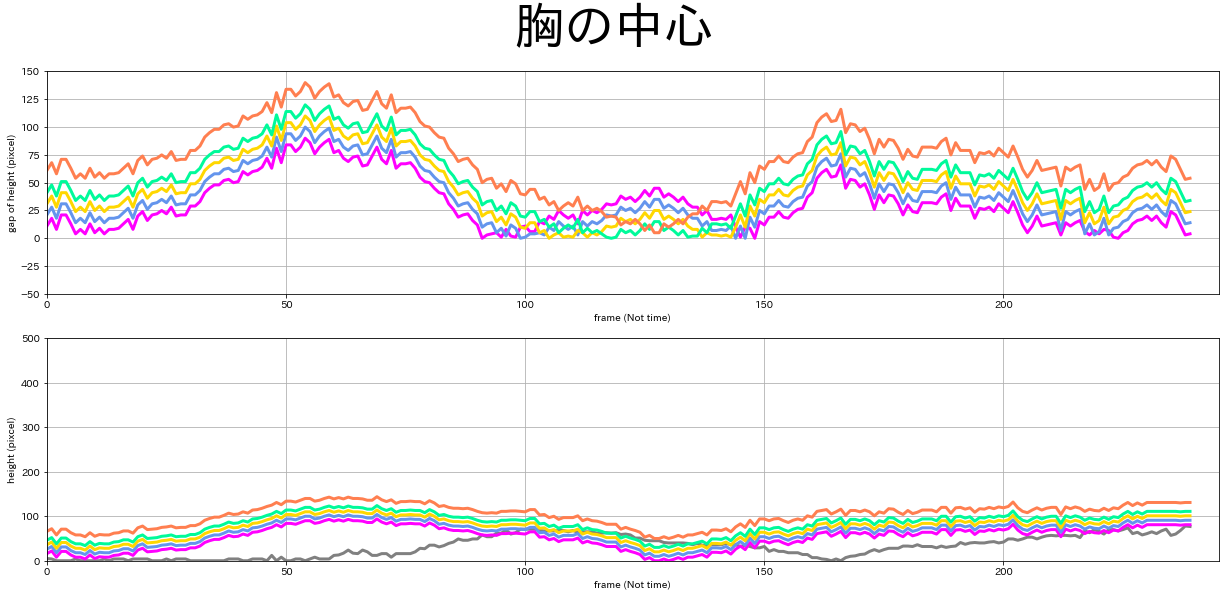

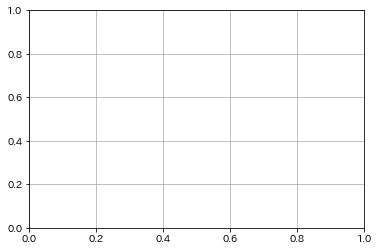

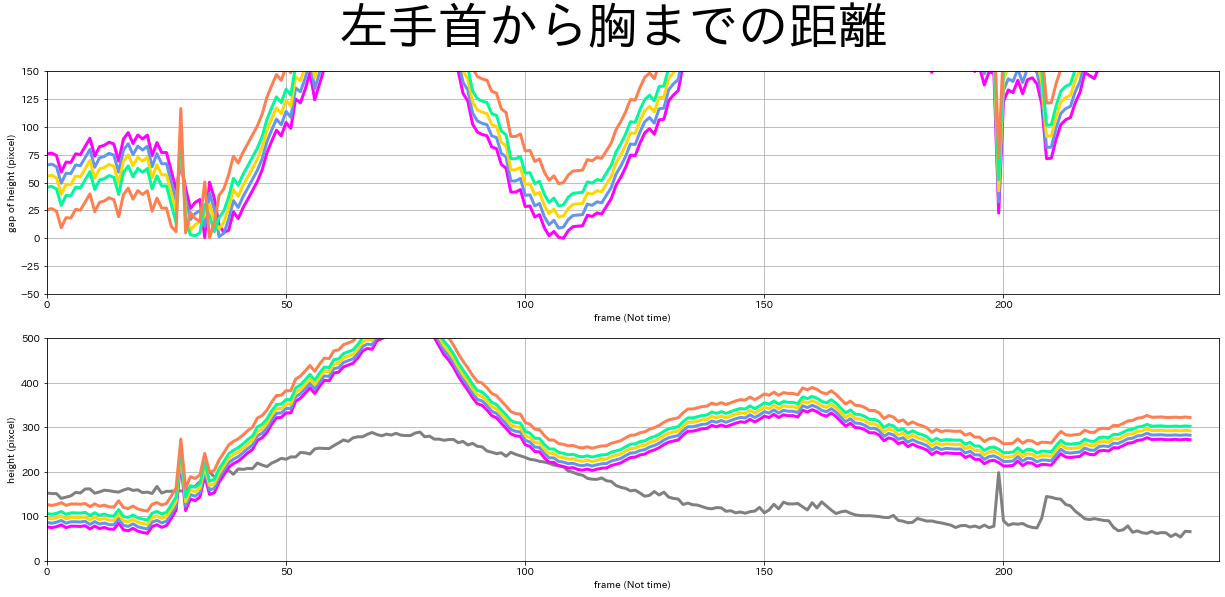

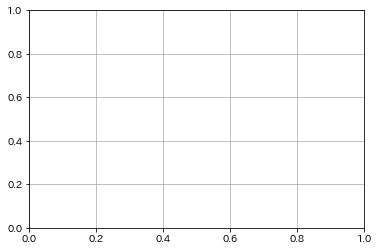

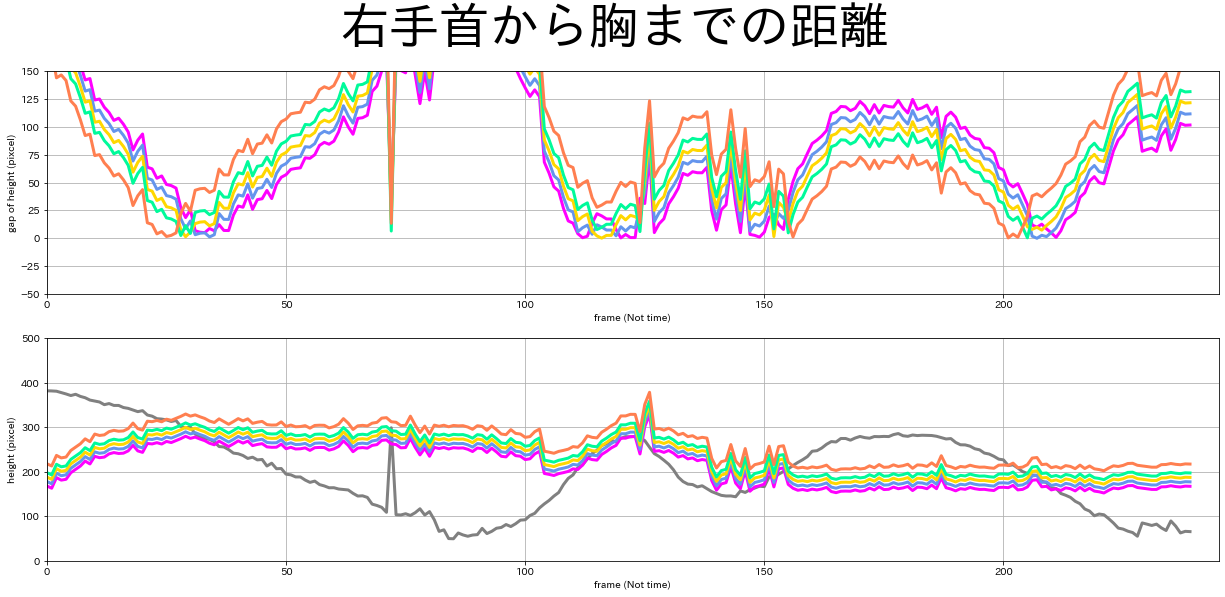

In [33]:
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
%matplotlib inline

from tqdm.autonotebook import tqdm

import japanize_matplotlib

PARTS_PATH="./fig/"

def AniFigure(PARTS_PATH, list_SELECTED_KEYPOINT, frames, df_A, df_B, df_C, df_D, df_E, df_F):

    dict_SELECTED_KEYPOINT={'left_shoulder_y':'左肩', 'right_shoulder_y':'右肩', 'left_elbow_y':'左肘', 'right_elbow_y':'右肘', 'left_wrist_y':'左手首', 'right_wrist_y':'右手首', 'middle_chest_y':'胸の中心',	'from_Rhand_to_chest':'左手首から胸までの距離',	'from_Lhand_to_chest':'右手首から胸までの距離'}

    #bodyRegion=['wrist_chest_distance_right',	'wrist_chest_distance_left']
    #------------------------------------------------------------------------------
    #関節部位ごとでグラフを作成する。
    #------------------------------------------------------------------------------
    for element in list_SELECTED_KEYPOINT:
      print('plotting %s ...' % element)
      print()
      import os 
      try:
        os.mkdir(PARTS_PATH)
      except:
        print('       the directory already exists')
        print()
      try:
        os.mkdir(PARTS_PATH+element+"/")
      except:
        print('       the directory already exists')
        print()

      df_A_element=df_A['%s' % element]
      df_B_element=df_B['%s' % element]
      df_C_element=df_C['%s' % element]
      df_D_element=df_D['%s' % element]
      df_E_element=df_E['%s' % element]
      df_F_element=df_F['%s' % element]
      #------------------------------------------------------------------------------
      # 描画するデータの準備
      #------------------------------------------------------------------------------
      list_x = []
      list_x.clear()

      y_now=df_A_element.values.tolist()
      y_B=df_B_element.values.tolist()
      y_C=df_C_element.values.tolist()
      y_D=df_D_element.values.tolist()
      y_E=df_E_element.values.tolist()
      y_F=df_F_element.values.tolist()

      y_dff_BA=abs(np.array(y_now[:(frames)]) - np.array(y_B[:(frames)]))
      y_dff_CA=abs(np.array(y_now[:(frames)]) - np.array(y_C[:(frames)]))
      y_dff_DA=abs(np.array(y_now[:(frames)]) - np.array(y_D[:(frames)]))
      y_dff_EA=abs(np.array(y_now[:(frames)]) - np.array(y_E[:(frames)]))
      y_dff_FA=abs(np.array(y_now[:(frames)]) - np.array(y_F[:(frames)]))
      #------------------------------------------------------------------------------
      #グラフを更新する
      #------------------------------------------------------------------------------
      # 描画領域
      fig = plt.figure()
      plt.grid(True, axis='both')
      fig = plt.figure(figsize=(21,9), facecolor='white')
      for frame in tqdm(range(0, frames,1)): #len(frames)
        plt.cla() #図をcloseする
        plt.clf() #図をclearする
        #spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratiosr='mediumspringgreen')
        spec = gridspec.GridSpec(ncols=1, nrows=2)
        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1])

        #------------------------------------------------------------------------------
        #グラフ下半分 (2つの投球をプロット)
        #------------------------------------------------------------------------------
        list_x.append(frame) 
        ax2.set_xlabel("frame (Not time)")
        ax2.set_ylabel("height (pixcel)")
        ax2.set_xlim((0, frames+5))
        ax2.set_ylim((0,500))
        ax2.grid(True, axis='both')

        ax2.plot(list_x, y_now[:(frame+1)], linewidth = 3, color='gray')
        ax2.plot(list_x, y_B[:(frame+1)], linewidth = 3, color='magenta') #'lightskyblue'
        ax2.plot(list_x, y_C[:(frame+1)], linewidth = 3, color='cornflowerblue') #'lightskyblue'
        ax2.plot(list_x, y_D[:(frame+1)], linewidth = 3, color='gold')
        ax2.plot(list_x, y_E[:(frame+1)], linewidth = 3, color='mediumspringgreen')
        ax2.plot(list_x, y_F[:(frame+1)], linewidth = 3, color='coral') #'lightskyblue'
        #------------------------------------------------------------------------------
        #グラフ上半分 (2投球の差分をプロット)
        #------------------------------------------------------------------------------
        ax1.set_xlabel("frame (Not time)")
        ax1.set_ylabel("gap of height (pixcel)")
        ax1.set_xlim((0, frames+5))
        ax1.set_ylim((-50,150))
        ax1.grid(True, axis='both')

        ax1.plot(list_x, y_dff_BA[:(frame+1)], linewidth = 3, color='magenta')
        ax1.plot(list_x, y_dff_CA[:(frame+1)], linewidth = 3, color='cornflowerblue')
        ax1.plot(list_x, y_dff_DA[:(frame+1)], linewidth = 3, color='gold')
        ax1.plot(list_x, y_dff_EA[:(frame+1)], linewidth = 3, color='mediumspringgreen')
        ax1.plot(list_x, y_dff_FA[:(frame+1)], linewidth = 3, color='coral')
        #------------------------------------------------------------------------------
        #全体的なグラフの処理
        #------------------------------------------------------------------------------
        # 折れ線グラフを再描画する
        fig.suptitle('%s' % dict_SELECTED_KEYPOINT[element] , fontsize=50)
        plt.savefig(PARTS_PATH+element+"/AniFig_%s.jpg" % (str(frame).zfill(5)), transparent = True, bbox_inches = 'tight', pad_inches = 0.1)
        #plt.show()
      #------------------------------------------------------------------------------
      print('       %s Done!' % element)
      print()
      #------------------------------------------------------------------------------
      
AniFigure(PARTS_PATH, list_SELECTED_KEYPOINT, min_frames, df_A, df_B, df_C, df_D, df_E, df_F)

##2.2. 静止画を重ねて動画を生成 (グラフを重ねてアニメーショングラフ化) する。

In [34]:
#------------------------------------------------------------------------------
#動画を生成
#------------------------------------------------------------------------------
def make_video(PATH, FILE):
  fps=59.94005994005994
  width =1920.0
  height =1080.0
  
  import glob
  images = glob.glob(PATH + "*.jpg")
  from natsort import natsorted
  images=sorted(images)

  import cv2
  print("画像を結合して動画を作成します...")
  fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
  PATH="./fig/" #動画を結合する関数の汎用化に合わせて、こ子でPATHを書き換えていることに注意。
  video = cv2.VideoWriter(PATH + FILE, fourcc, fps, (int(width), int(height)))

  from tqdm.autonotebook import tqdm
  for i in tqdm(range(len(images))):
     img = cv2.resize(cv2.imread(images[i]),(int(width),int(height)))
     video.write(img) 

  video.release()
  print("%sにおいて、\n%sを作成しました。" % (PATH, FILE))
  print()
  print('終了')
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#関節部位ごとでグラフを作成する。
#------------------------------------------------------------------------------
for element in list_SELECTED_KEYPOINT:
  make_video(PARTS_PATH+element+'/', '%s.MP4' % element)
  print("出力画像 : ", './fig/'+'%s.MP4' % element)
#------------------------------------------------------------------------------

画像を結合して動画を作成します...



./fig/において、
left_shoulder_y.MP4を作成しました。

終了
出力画像 :  ./fig/left_shoulder_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_shoulder_y.MP4を作成しました。

終了
出力画像 :  ./fig/right_shoulder_y.MP4
画像を結合して動画を作成します...



./fig/において、
left_elbow_y.MP4を作成しました。

終了
出力画像 :  ./fig/left_elbow_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_elbow_y.MP4を作成しました。

終了
出力画像 :  ./fig/right_elbow_y.MP4
画像を結合して動画を作成します...



./fig/において、
left_wrist_y.MP4を作成しました。

終了
出力画像 :  ./fig/left_wrist_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_wrist_y.MP4を作成しました。

終了
出力画像 :  ./fig/right_wrist_y.MP4
画像を結合して動画を作成します...



./fig/において、
middle_chest_y.MP4を作成しました。

終了
出力画像 :  ./fig/middle_chest_y.MP4
画像を結合して動画を作成します...



./fig/において、
from_Rhand_to_chest.MP4を作成しました。

終了
出力画像 :  ./fig/from_Rhand_to_chest.MP4
画像を結合して動画を作成します...



./fig/において、
from_Lhand_to_chest.MP4を作成しました。

終了
出力画像 :  ./fig/from_Lhand_to_chest.MP4


https://watlab-blog.com/2019/09/29/movie-space-combine/

#3. 動画を表示する。(ループ文で表示できないため使わない。)

In [35]:
#------------------------------------------------------------------------------
#動画を表示 (動画のサイズが大きいとエラーになります。)
#------------------------------------------------------------------------------
import base64
import io
from IPython.display import HTML
def play_movie(mp4_path):
  video = io.open(mp4_path, 'r+b').read()
  encoded = base64.b64encode(video)
  return HTML(data='''<video width='640' height='480' loop='true' autoplay='true' controls> 
                      <source src='data:video/mp4;base64,{0}' type='video/mp4'/>
                      </video>'''.format(encoded.decode('utf-8')))
  
#play_movie(PARTS_PATH+element+'/'+'%s.MP4' % element)
#------------------------------------------------------------------------------

#4. データの整理

##4.1 保存する動画を指定

In [36]:
#------------------------------------------------------------------------------
#関節部位ごとにグラフを作成する。
#------------------------------------------------------------------------------
#list_SELECTED_KEYPOINT=['left_shoulder_y', 'right_shoulder_y', 'left_elbow_y', 'right_elbow_y', 'left_wrist_y', 'right_wrist_y', 'middle_chest_y',	'from_Rhand_to_chest',	'from_Lhand_to_chest'] #bodyRegion='部位(?)'

save_List=list_SELECTED_KEYPOINT
#save_List=bodyRegion+["result.MP4"]
print(save_List)

['left_shoulder_y', 'right_shoulder_y', 'left_elbow_y', 'right_elbow_y', 'left_wrist_y', 'right_wrist_y', 'middle_chest_y', 'from_Rhand_to_chest', 'from_Lhand_to_chest']


##4.2. フォルダ名を変数にするため、現在の時刻を取得する。

In [37]:
import datetime
from pytz import timezone
dates=datetime.datetime.now(timezone('Asia/Tokyo'))
exept_microsec=dates.strftime("%Y-%m-%d-%H-%M")
print('[Today : %s]' % str(exept_microsec))

DATETIME=exept_microsec

[Today : 2020-12-09-18-10]


##4. 保存するフォルダを作成

In [38]:
import os

OUTPUT_DIR=OUTPUT_PATH+ "PoseEstim_%s/" % DATETIME
OUTPUT_DIR_RESULTS=OUTPUT_PATH+ "PoseEstim_%s/results/" % DATETIME

try:
  os.mkdir(OUTPUT_DIR)
except:
  print(OUTPUT_DIR, '    already exists')
  print()
try:
  os.mkdir(OUTPUT_DIR_RESULTS)
except:
  print(OUTPUT_DIR_RESULTS, '    the directory already exists')
  print()

In [39]:
import shutil
for element in save_List:
  shutil.copy('./fig/%s.MP4' % element, OUTPUT_DIR_RESULTS)

shutil.copy(main_CSV_FILE, OUTPUT_DIR)
shutil.copy(sub_CSV_FILE_01, OUTPUT_DIR)
shutil.copy(sub_CSV_FILE_02, OUTPUT_DIR)
shutil.copy(sub_CSV_FILE_03, OUTPUT_DIR)
shutil.copy(sub_CSV_FILE_04, OUTPUT_DIR)
shutil.copy(sub_CSV_FILE_05, OUTPUT_DIR)

'/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/PoseEstim_2020-12-09-18-10/pose-data_C0219.csv'

##4.5.  不要なデータの削除 (google driveで動かしてる時は使わなくてもいい)

In [40]:
import shutil
print('使用済みデータを削除します...')
print()

shutil.rmtree("./fig/")
print("削除完了")

使用済みデータを削除します...

削除完了
